<a id='FigureExperimentalDataModelTop'></a>
# Figures Illustrating Model Predictions on the Experimental Dataset

Illustrations of the performance of the ensemble of LSTM networks, predicting the final (equilibrium) magnitude of the porous silicon (PSi) sensor response. At every time point the models prediction is based on data from the current and past timesteps.

1. [Representive examples of ensemble LSTM model predictions (mean & variance) and ground truth](#FigureExperimentalDataModelTop)
2. [Panel plot of representive examples of ensemble LSTM model predictions (mean & variance) and ground truth](#FiguresExperimentalDataModelSection2)
3. [Histogram comparing distributions of t90 times for original experimental data and LSTM ensemble model predictions, with additional variance subplot indicating S/N](#FiguresExperimentalDataModelSection3)
4. [Box and whisker plot of ratio of experimental to experimental data model predicted t90 times](#FiguresExperimentalDataModelSection4)
5. [Plot of mean and median factor of improvement in t90 response time achieved using predictions from LSTM ensembles containing 1 to 30 base learners](#FiguresExperimentalDataModelSection5)
6. [Ensemble LSTM model predictions (mean & variance) and ground truth for every example in the dataset](#FiguresExperimentalDataModelSection6)
7. [Plot of individual base learner predictions, aggregated ensemble prediction, and experimental sensor response](#FiguresExperimentalDataModelSection7)

Followed by a [comparison of different types of recurrent neural network](#FiguresExperimentalDataModelAlternativeModels)

<a id='figures_experimental_data_model_section1'></a>
## 1. Representive examples of ensemble LSTM model predictions (mean & variance) and ground truth
[return to top](#FigureExperimentalDataModelTop)

1/1 [==============================] - 0s 377ms/step


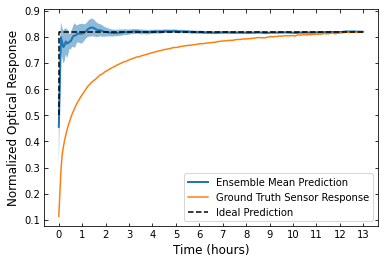

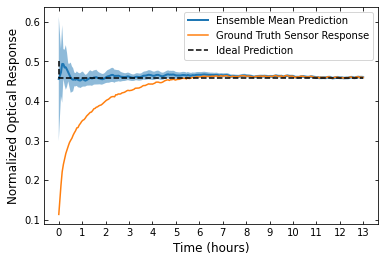

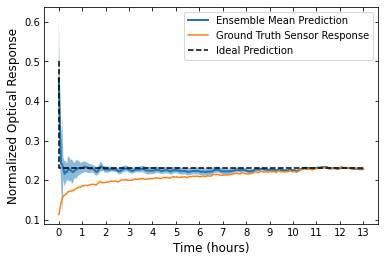

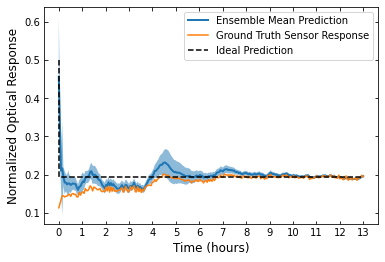

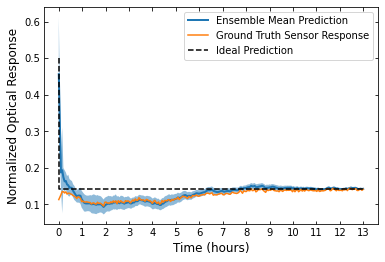

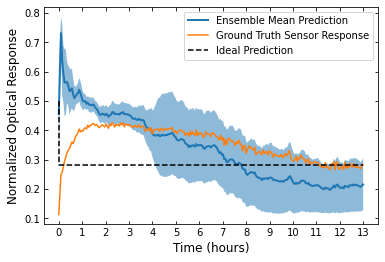

In [7]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
experiment_num = [11,46,57,39,47,59]
test_split = 0.2
# standard deviations away from the mean used to show confidence interval
# 1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively
StdevsFromMean = 2 

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)

# make a new tensor containing all representative experiments
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each representative experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    prediction = bestModel.predict(X_predict)
    Mean += prediction[:,:,0]
    Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2

Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)

# for plotting the ideal model prediction, which instantaneously rises to the equilibrium value at time t=0
idealTime = np.append([0.], time.iloc[:,].values)

time = np.array(time, dtype=float)

for mean,x,stdev,num in zip(Mean,X_predict,Stdev,experiment_num):
    
    # the ideal prediction is ~0.5 on the normalized sensor response scale initially,
    # then jumps to the equilibrium sensor response and remains there for all subsequent time points
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    fig, ax = plt.subplots()

    # uncertainty is displayed by a shaded region a specified number of standard deviations from the mean
    ax.fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
    
    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()#loc='upper right')
    
    plt.savefig(f"../Figures/ExperimentalEnsemblePredictionIdealResponses{num}.png", dpi=200, bbox_inches='tight')
    plt.show()

<a id='FiguresExperimentalDataModelSection2'></a>
## 2. Panel plot of representive examples of ensemble LSTM model predictions (mean & variance) and ground truth
[return to top](#FigureExperimentalDataModelTop)

1/1 [==============================] - 0s 384ms/step


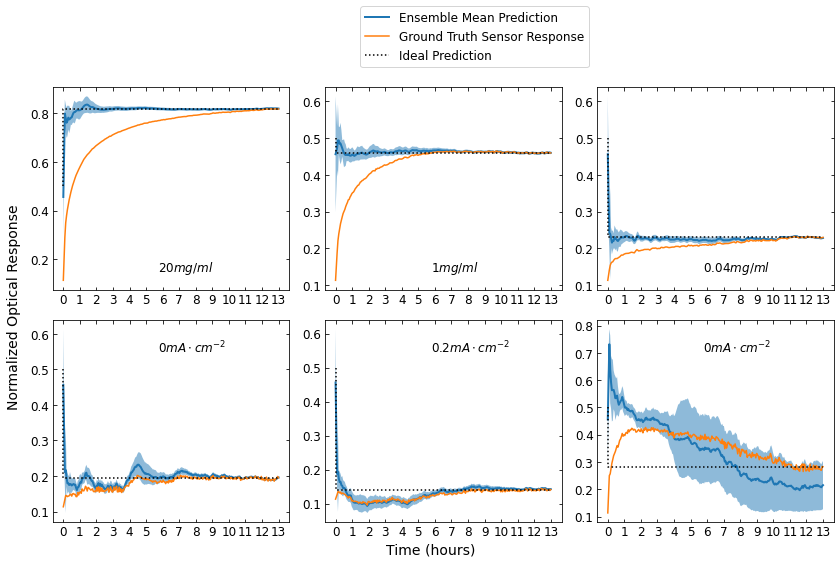

In [6]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
experiment_num = [11,39,46,47,57,59]
test_split = 0.2
# standard deviations away from the mean used to show confidence interval
# 1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively
StdevsFromMean = 2 

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)

# make a new tensor containing all representative experiments
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each representative experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    prediction = bestModel.predict(X_predict)
    Mean += prediction[:,:,0]
    Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2

Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)

# for plotting the ideal model prediction, which instantaneously rises to the equilibrium value at time t=0
idealTime = np.append([0.], time.iloc[:,].values)

time = np.array(time, dtype=float)

fig, ax = plt.subplots(2, 3)

# coordinates of each plot in the panel 
ii = [0,1,0,1,0,1]
jj = [0,0,1,1,2,2]

for mean,x,stdev,num,i,j in zip(Mean,X_predict,Stdev,experiment_num,ii,jj):
    
    # the ideal prediction is ~0.5 on the normalized sensor response scale initially,
    # then jumps to the equilibrium sensor response and remains there for all subsequent time points
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    # uncertainty is displayed by a shaded region a specified number of standard deviations from the mean
    ax[i,j].fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    
    ax[i,j].plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    ax[i,j].plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    ax[i,j].plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle=':',linewidth=1.5)
    
    ax[i,j].tick_params(right=True, top=True, labelleft=True, labelright=False, labelbottom=True, labeltop=False, labelsize=12)
    ax[i,j].tick_params(direction="in")
    ax[i,j].set_xticks(range(14))
    ax[i,j].tick_params(axis="both", which="both", direction="in")

# arbitrary positioning of x and y axis labels, and concentration labels
fig.text(0.5, 0.07, 'Time (hours)', ha='center', fontsize=14)
fig.text(0.08, 0.5, 'Normalized Optical Response', va='center', rotation='vertical', fontsize=14)
fig.text(0.23, 0.56, '20'+ r'$mg / ml$',fontsize=12)
fig.text(0.5, 0.56, '1'+ r'$mg / ml$',fontsize=12)
fig.text(0.77, 0.56, '0.04'+ r'$mg / ml$',fontsize=12)
fig.text(0.23, 0.42, '0'+ r'$mA \cdot cm^{-2}$',fontsize=12)
fig.text(0.5, 0.42, '0.2'+ r'$mA \cdot cm^{-2}$',fontsize=12)
fig.text(0.77, 0.42, '0'+ r'$mA \cdot cm^{-2}$',fontsize=12)

ax[0,0].legend(loc=[1.3,1.1],fontsize=12)

plt.tick_params(right = False)
plt.subplots_adjust(wspace=0.15, hspace=0.15)
fig.set_figwidth(14)
fig.set_figheight(8)
    
plt.savefig(f"../Figures/PanelExperimentalEnsemblePredictionIdealResponses.png", dpi=200, bbox_inches='tight')
plt.show()

<a id='FiguresExperimentalDataModelSection3'></a>
## 3. Histogram comparing distributions of t90 times for original experimental data and LSTM ensemble model predictions, with additional variance subplot indicating S/N
[return to top](#FigureExperimentalDataModelTop)

3/3 [==============================] - 0s 32ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.551501
std     3.583923
min     0.051990
25%     0.155969
50%     0.701863
75%     3.769262
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466

ratio of experimental to predicted t90 summary statistics
                0
count   78.000000
mean    18.362022
std     26.591927
min      0.135135
25%      0.997000
50%      5.041667
75%     19.900000
max    106.000000


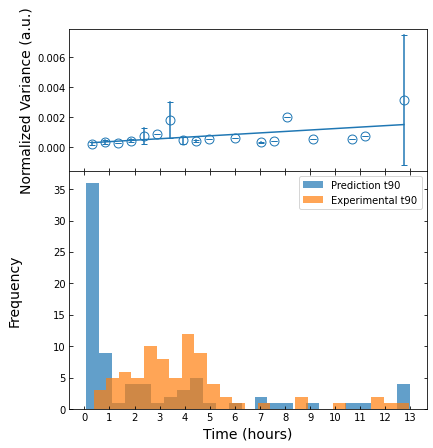

In [2]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
# t90 time is defined as the time until the response settles to within the following fraction of
# the equilibrium response indefinitely
t90Window = 0.1
test_split = 0.2
NumberOfBins = 25
markerSize = 80

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

MeanImprovementEnsembleSizes = []
MedianImprovementEnsembleSizes = []

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)
    
Mean = tf.zeros([len(X_test),SequenceLength])
Variance = tf.zeros([len(X_test),SequenceLength])
Prediction = tf.zeros([len(X_test),SequenceLength])

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # at a time, perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_test[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X_test)
    
    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_test[i,::], 0)) for  i in range(len(X_test))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X_test,Variance):
    
    # boolean array for each experimental sensor response time series of when the model prediction or experimental response
    # was within +/-10% of the final equilibrium experimental sensor response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    
    # finds the latest time point at which the model prediction or experimental measurement
    # was outisde the range of final equilibrium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    # average variance normalized by the magnitude of the final equilibrium sensor response  (indicative of S/N)
    NormVariance = variance/x[-1]
    MeanNormVariance.append(np.mean(NormVariance))

# convert t90 index to time in hours using the time array
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

MeanNormVariance = np.array(MeanNormVariance)

# descriptive statistics of t90 times for the experimental data, model predictions,
# and their ratio (ie. factor of improvement)
print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

# compose histogram comparing the experimental and predicted t90 distributions
freq, bins = np.histogram(PredictionT90, NumberOfBins)
BinNormVarianceMean = []
BinNormVarianceStdev = []

# for the experimental examples in each bin of the histogram, calculate the mean and the standard deviation of
# all the normalized variances
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 <= bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

BinCenters = np.array([(bins[i+1]+bins[i])/2 for i in range(NumberOfBins)])
BinNormVarianceMean = np.array(BinNormVarianceMean)
BinNormVarianceStdev = np.array(BinNormVarianceStdev)

# fitting a linear trendline to normalized variance data points for each histogram bin
LinearFit = LinearRegression()
BinCentersDropNa = BinCenters[~np.isnan(BinNormVarianceMean)]
BinNormVarianceMeanDropNa = BinNormVarianceMean[~np.isnan(BinNormVarianceMean)]
BinNormVarianceStdevDropNa = BinNormVarianceStdev[~np.isnan(BinNormVarianceMean)]
LinearFit.fit(np.reshape(BinCentersDropNa,(-1, 1)), np.reshape(BinNormVarianceMeanDropNa,(-1, 1)))

# plot normalized variance in subplot/axis 1, and histogram in subplot/axis 2
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1.8, 3]},figsize=[6.4, 7])

ax1.scatter(BinCentersDropNa,BinNormVarianceMeanDropNa, facecolor=(0,0,0,0), marker='o', s=markerSize, edgecolor='tab:blue')#
ax1.plot([BinCentersDropNa, BinCentersDropNa], [BinNormVarianceMeanDropNa+BinNormVarianceStdevDropNa, BinNormVarianceMeanDropNa-BinNormVarianceStdevDropNa], marker="_", color='tab:blue')
ax1.plot(BinCentersDropNa,LinearFit.predict(np.reshape(BinCentersDropNa,(-1, 1))),color='tab:blue')
ax1.set_ylabel('Normalized Variance (a.u.)', fontsize = 14)
ax1.tick_params(direction="in")

ax2.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90',color='tab:blue')
ax2.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90',color='tab:orange')
ax2.set_ylabel('Frequency', fontsize = 14, labelpad=32)
ax2.set_xlabel('Time (hours)', fontsize = 14)
ax2.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax2.tick_params(direction="in")
ax2.set_xticks(range(14))
ax2.legend(loc='upper right')

fig.subplots_adjust(hspace=0)

plt.savefig(".."+"/Figures/PredictedExperimentalt90HistogramNormVariance.png", dpi=200, bbox_inches='tight')
plt.show()

<a id='FiguresExperimentalDataModelSection4'></a>
## 4. Box and whisker plot of ratio of experimental to experimental data model predicted t90 times
[return to top](#FigureExperimentalDataModelTop)

3/3 [==============================] - 0s 32ms/step

ratio of experimental to predicted t90 summary statistics
                0
count   78.000000
mean    18.619599
std     26.613287
min      0.135135
25%      1.007753
50%      5.070833
75%     26.250000
max    106.000000


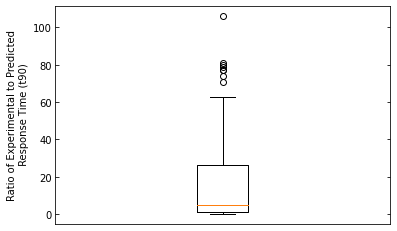

In [4]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
# t90 time is defined as the time until the response settles to within the following fraction of
# the equilibrium response indefinitely
t90Window = 0.1
test_split = 0.2

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)
    
Mean = tf.zeros([len(X_test),SequenceLength])
Prediction = tf.zeros([len(X_test),SequenceLength])

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_test[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X_test)
    
    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_test[i,::], 0)) for  i in range(len(X_test))])
    
    Mean += Prediction[:,:,0]
        
Mean /= NumEnsemble

PredictionT90 = []
ExperimentalT90 = []

for mean,x in zip(Mean,X_test):
    
    # boolean array for each experimental sensor response time series of when the model prediction or experimental response
    # was within +/-10% of the final equilibrium experimental sensor response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    
    # finds the latest time point at which the model prediction or experimental measurement
    # was outisde the range of final equilibrium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
   
# convert t90 index to time in hours using the time array
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

# ratio between experimental and LSTM ensemble prediction t90 times
RatioT90 = np.array(ExperimentalT90)/np.array(PredictionT90)

print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(RatioT90).describe())

# plot box and whisker plot of the ratio between experimental and predicted t90 times
fig, ax = plt.subplots()
ax.boxplot(RatioT90)
plt.ylabel("Ratio of Experimental to Predicted\n Response Time (t90)")
ax.tick_params(right=True, top=False, bottom=False, labelbottom=False, labelright=False, labeltop=False)
ax.tick_params(direction="in")

plt.savefig("../Figures/BoxandWhiskerPlotExperimentalPredictedt90Ratio.png", dpi=200, bbox_inches='tight')
plt.show()

<a id='FiguresExperimentalDataModelSection5'></a>
## 5. Plot of mean and median factor of improvement in t90 response time achieved using predictions from LSTM ensembles containing 1 to 30 base learners
[return to top](#FigureExperimentalDataModelTop)

3/3 [==============================] - 0s 33ms/step - loss: -3.9071
Number of Base Learners = 1
3/3 [==============================] - 0s 28ms/step
Number of Base Learners = 2
3/3 [==============================] - 0s 28ms/step
Number of Base Learners = 3
3/3 [==============================] - 1s 32ms/step
Number of Base Learners = 4
3/3 [==============================] - 0s 32ms/step
Number of Base Learners = 5
3/3 [==============================] - 0s 33ms/step
Number of Base Learners = 6
3/3 [==============================] - 1s 28ms/step
Number of Base Learners = 7
3/3 [==============================] - 0s 30ms/step
Number of Base Learners = 8
3/3 [==============================] - 0s 28ms/step
Number of Base Learners = 9
3/3 [==============================] - 0s 32ms/step
Number of Base Learners = 10
3/3 [==============================] - 0s 33ms/step
Number of Base Learners = 11
3/3 [==============================] - 0s 24ms/step
Number of Base Learners = 12
3/3 [================

3/3 [==============================] - 0s 28ms/step
Number of Base Learners = 24
3/3 [==============================] - 0s 31ms/step
Number of Base Learners = 25
3/3 [==============================] - 1s 32ms/step
Number of Base Learners = 26
3/3 [==============================] - 0s 32ms/step
Number of Base Learners = 27
3/3 [==============================] - 0s 23ms/step
Number of Base Learners = 28
3/3 [==============================] - 0s 33ms/step
Number of Base Learners = 29
3/3 [==============================] - 0s 33ms/step
Number of Base Learners = 30
3/3 [==============================] - 1s 24ms/step


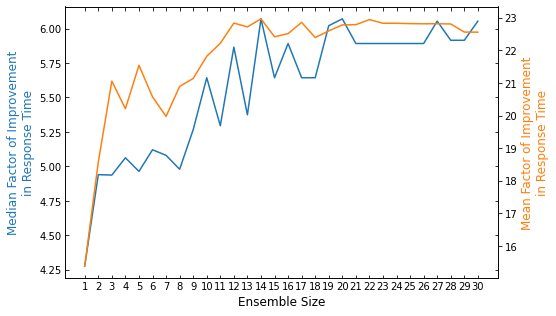

In [5]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

## input parameters
TrainedBaseLearners = 30
validation_split = 0.25
SequenceLength = 250
# t90 time is defined as the time until the response settles to within the following fraction of
# the equilibrium response indefinitely
t90Window = 0.1
test_split = 0.2

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

train_concentrations = df_train.iloc[:,0]

df_train, df_val = train_test_split(df_train, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=train_concentrations)

# normalise time series data
df_norm_train, df_norm_test, df_norm_val = ExperimentalData.NormalizeData(df_train,df_test,df_val)

# Define y as the last element in X, and ensure X and y are the correct shape
X_val, y_val = ExperimentalData.Shape(df_norm_val)

MeanImprovementEnsembleSizes = []
MedianImprovementEnsembleSizes = []
ValLossRanking = []

# establishing each base learner's performance on the validation set
for i in range(TrainedBaseLearners):
        checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
        bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        ValLossRanking.append(bestModel.evaluate(X_val, y_val))

# ordering models in terms of best performance on validation set
ModelRankingValLoss = np.array(ValLossRanking).argsort()

# for every ensemble size between 1 and TrainedBaseLearners, calculate mean and median factor of improvement
# in t90 response time afforded by the ensemble predictions
for NumEnsemble in range(1,TrainedBaseLearners+1):
    print("Number of Base Learners = "+str(NumEnsemble))
    Mean = tf.zeros([len(X_val),SequenceLength])
    Variance = tf.zeros([len(X_val),SequenceLength])
    Prediction = tf.zeros([len(X_val),SequenceLength])

    # predict equilibrium sensor response for each base LSTM learner in the ensemble
    # at every time point for each experimental example
    # implementation follows this work: doi.org/10.48550/arXiv.1612.01474
    for i in range(NumEnsemble):
        checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(ModelRankingValLoss[i]+1)
        bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # at a time, perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_val[0:6,::] for example does give identical results to predicting any one indivdually..
        Prediction = bestModel.predict(X_val)

        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_val[i,::], 0)) for  i in range(len(X_val))])

        Mean += Prediction[:,:,0]
        Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2

    Mean /= NumEnsemble
    Variance /= NumEnsemble
    Variance -= Mean**2

    PredictionT90 = []
    ExperimentalT90 = []

    for mean,x,variance in zip(Mean,X_val,Variance):

        # boolean array for each experimental sensor response time series of when the model prediction or experimental response
        # was within +/-10% of the final equilibrium experimental sensor response
        PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

        # finds the latest time point at which the model prediction or experimental measurement
        # was outisde the range of final equilibrium response +/- 10%
        PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

    # convert t90 index to time in hours using the time array
    PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
    ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

    # mean and median factor of improvement in t90 response time using LSTM network ensembles of different sizes
    MeanImprovementEnsembleSizes.append(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).mean())
    MedianImprovementEnsembleSizes.append(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).median())

fig, ax = plt.subplots(figsize=[7.75, 5])

ax.plot(range(1,len(MedianImprovementEnsembleSizes)+1),MedianImprovementEnsembleSizes,color="tab:blue",label="Median Response Time Improvement")
ax.set_xlabel('Ensemble Size', fontsize = 12)
ax2 = ax.twinx()
ax2.plot(range(1,len(MeanImprovementEnsembleSizes)+1),MeanImprovementEnsembleSizes,color="tab:orange",label="Mean Response Time Improvement")
ax2.set_ylabel('Mean Factor of Improvement\nin Response Time',color="tab:orange",fontsize = 12)
ax.set_ylabel('Median Factor of Improvement\nin Response Time',color="tab:blue",fontsize = 12)
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(1,TrainedBaseLearners+1))

plt.savefig("../Figures/EnsembleSizeResponseTimeImprovement.png", dpi=200, bbox_inches='tight')
plt.show()

<a id='FiguresExperimentalDataModelSection6'></a>
## 6. Ensemble LSTM model predictions (mean & variance) and ground truth for every example in the dataset
[return to top](#FigureExperimentalDataModelTop)

3/3 [==============================] - 0s 32ms/step


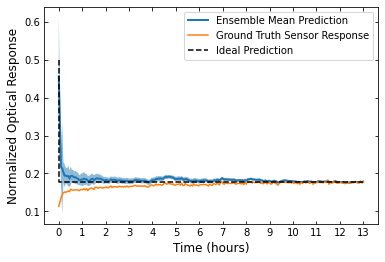

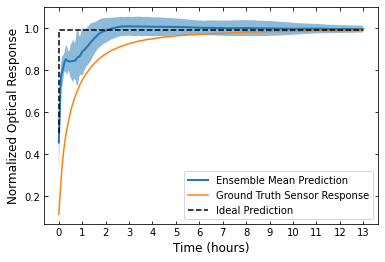

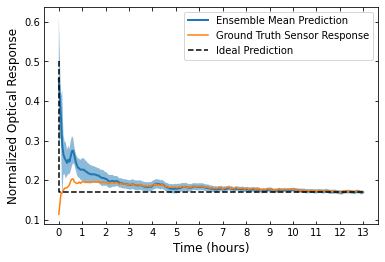

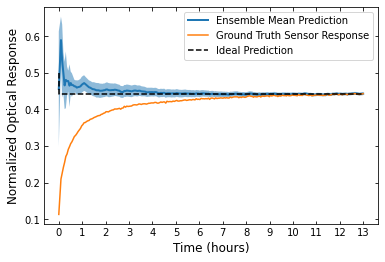

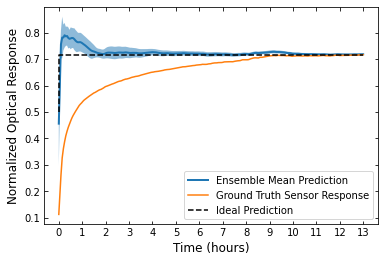

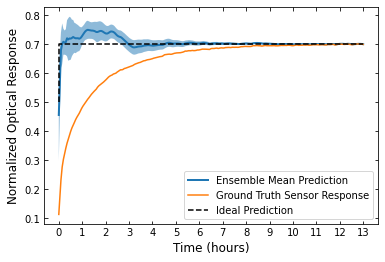

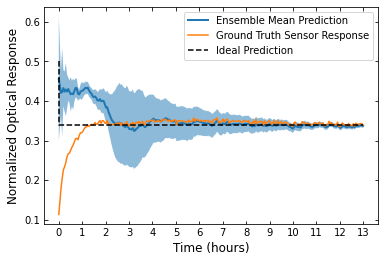

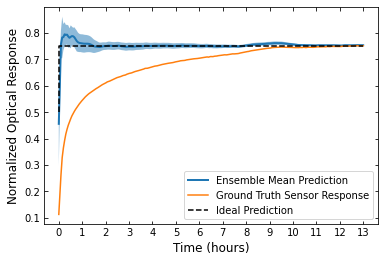

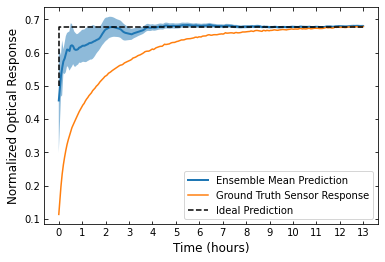

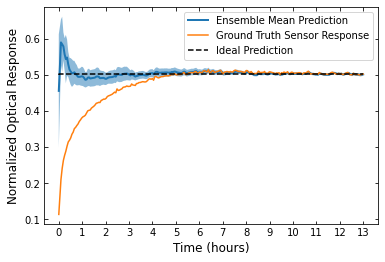

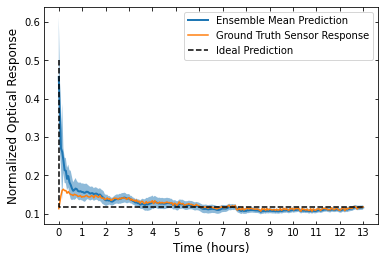

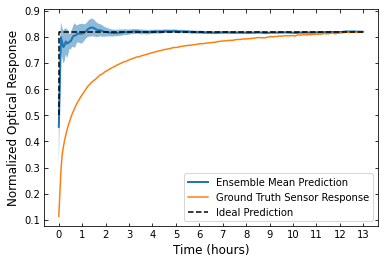

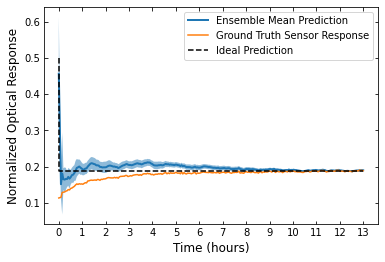

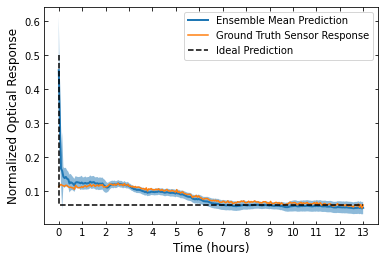

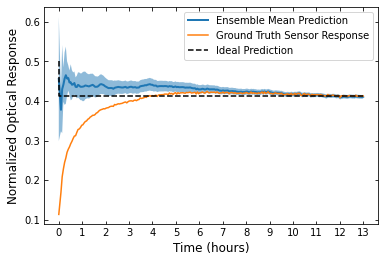

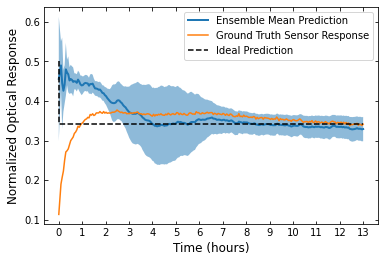

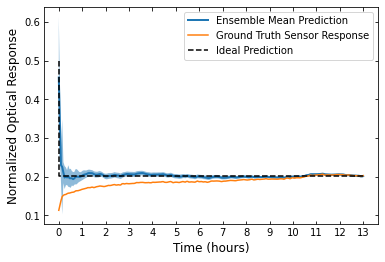

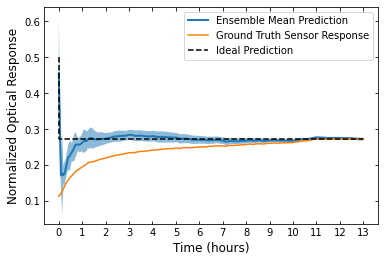

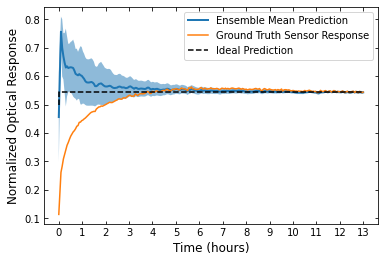

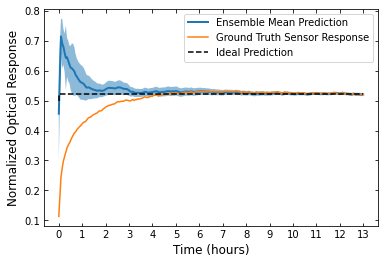

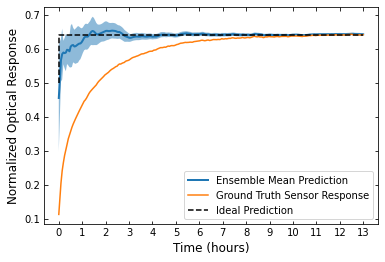

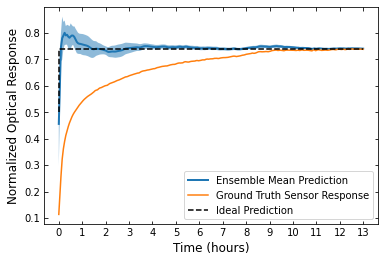

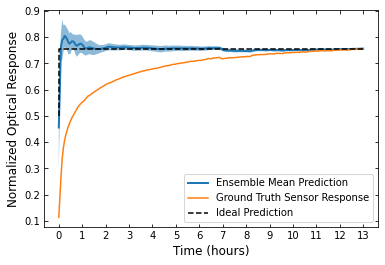

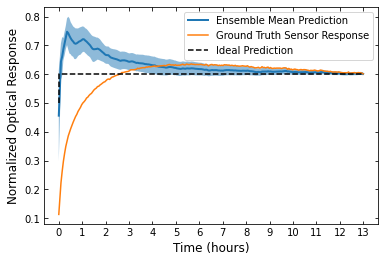

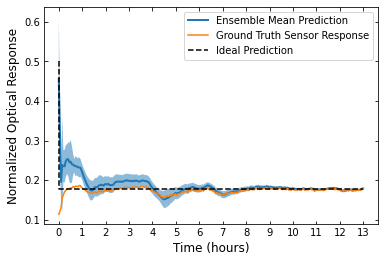

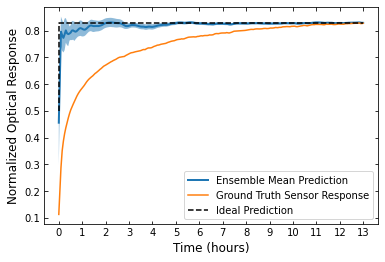

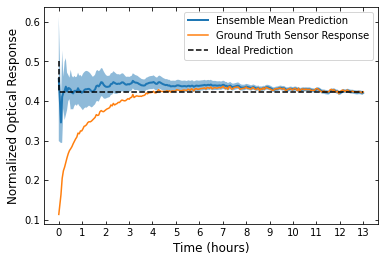

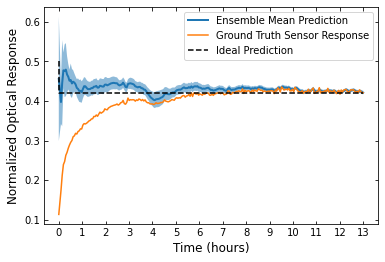

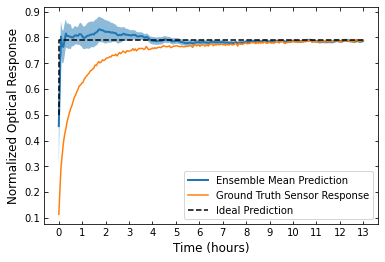

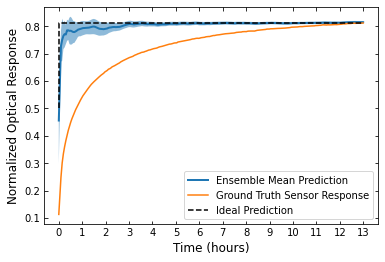

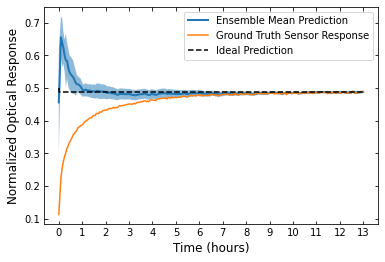

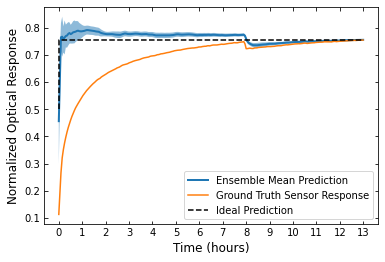

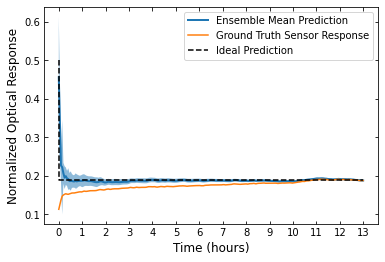

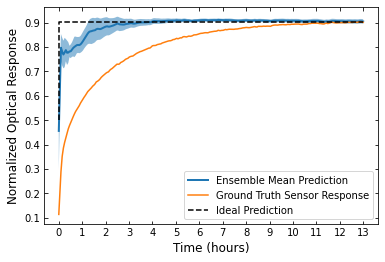

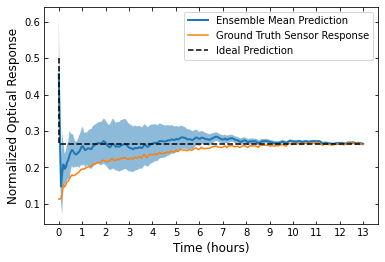

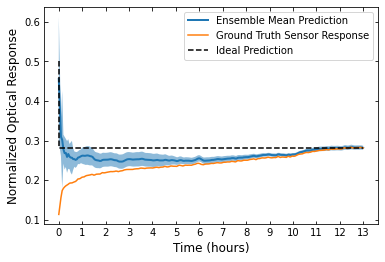

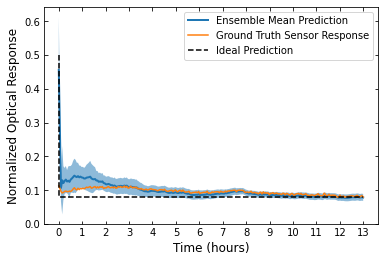

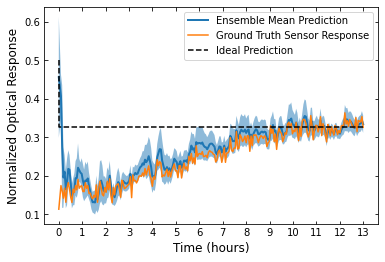

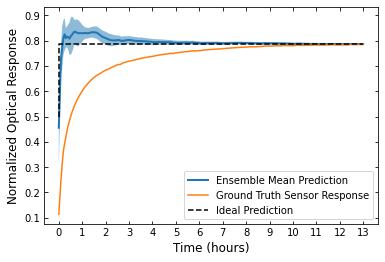

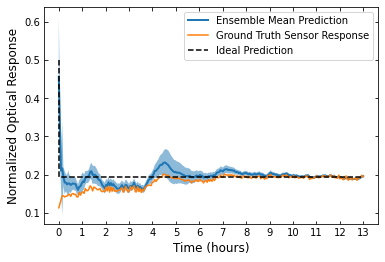

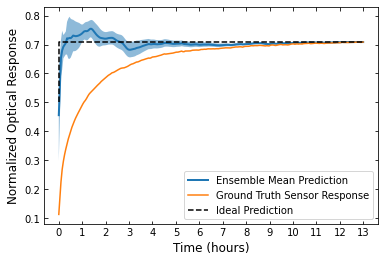

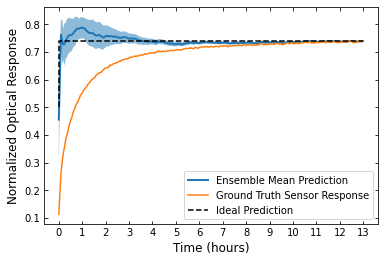

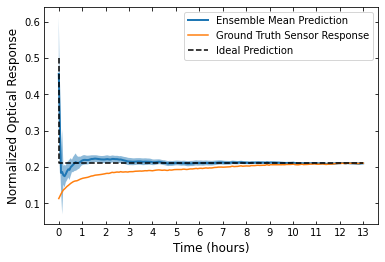

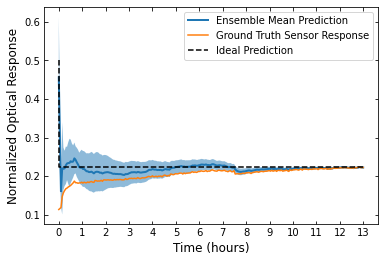

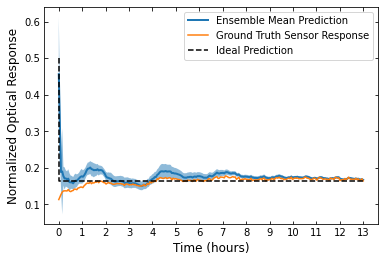

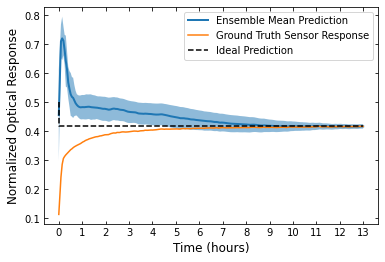

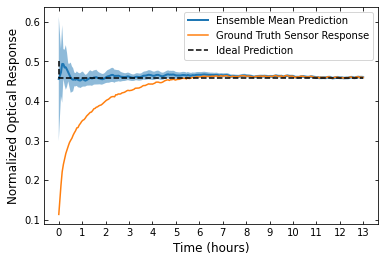

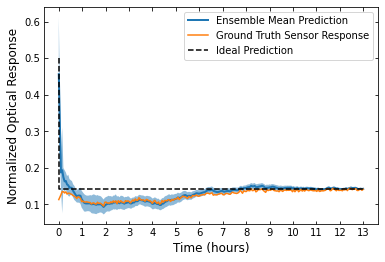

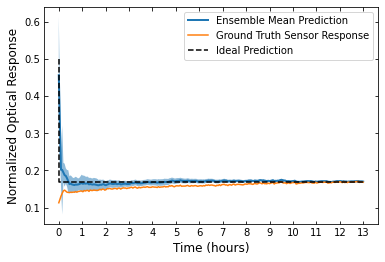

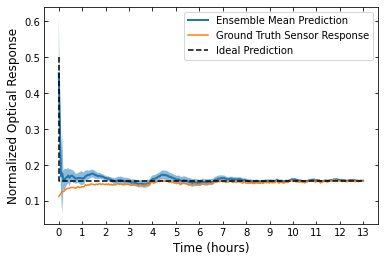

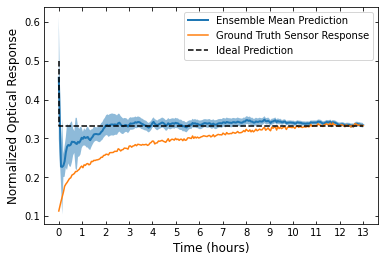

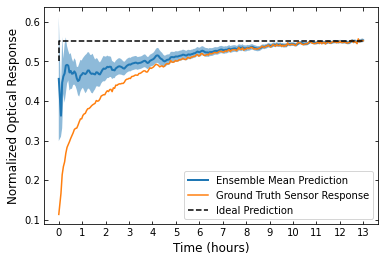

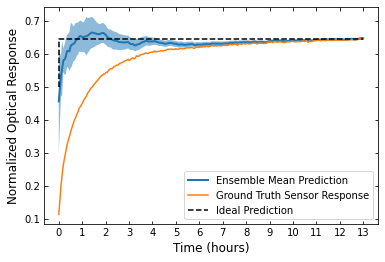

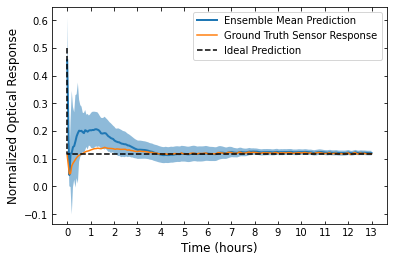

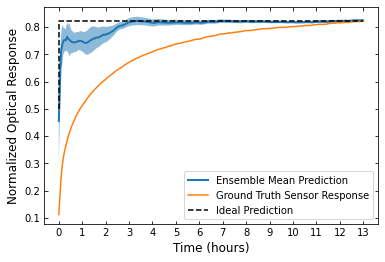

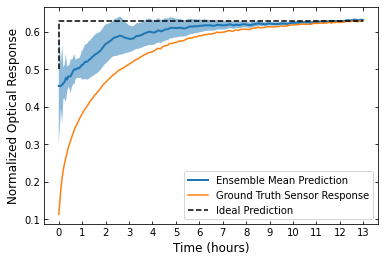

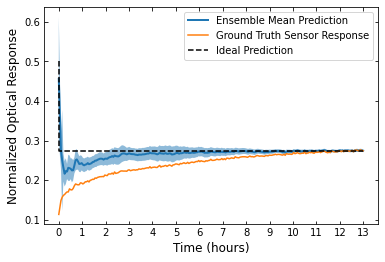

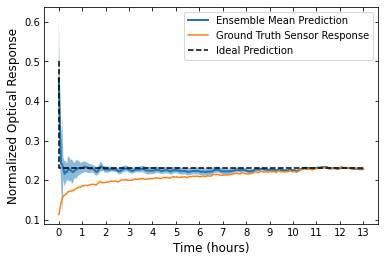

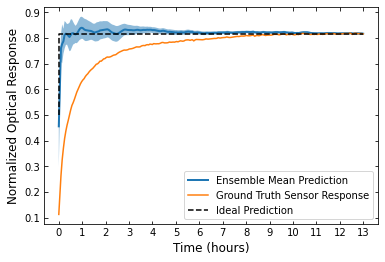

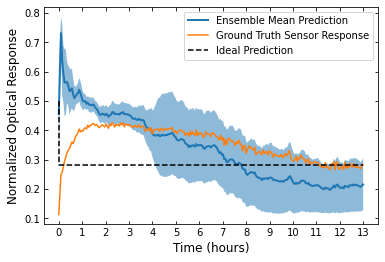

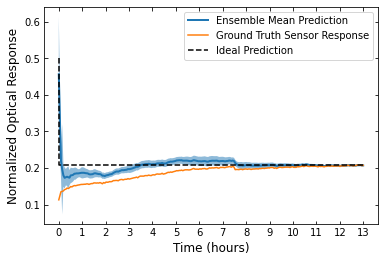

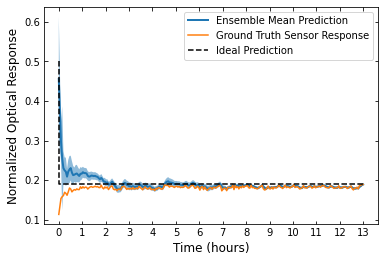

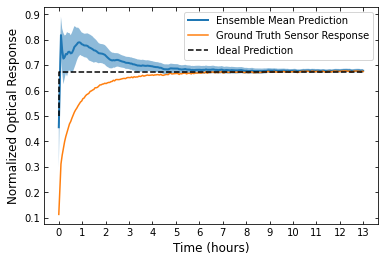

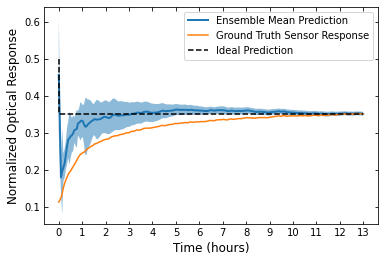

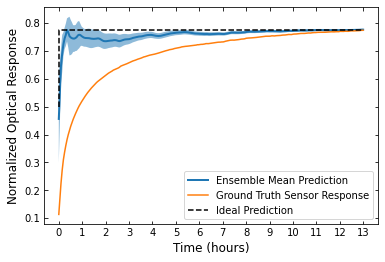

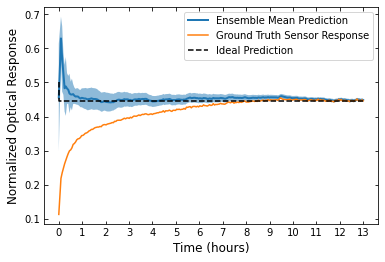

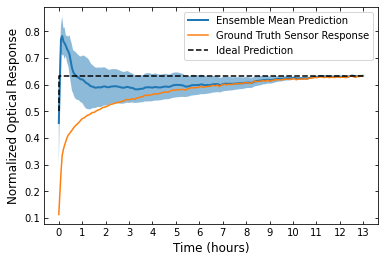

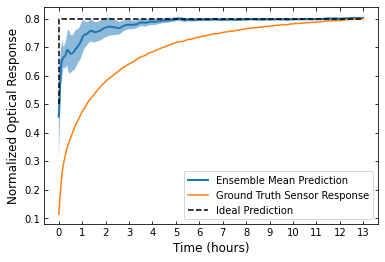

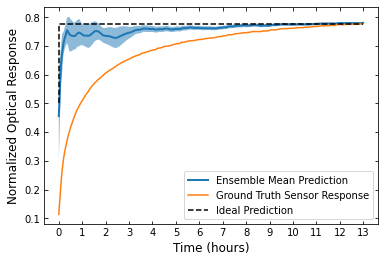

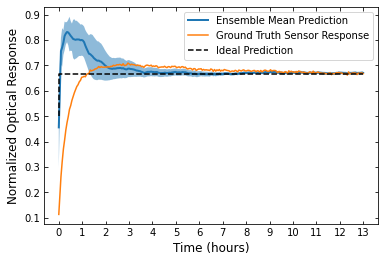

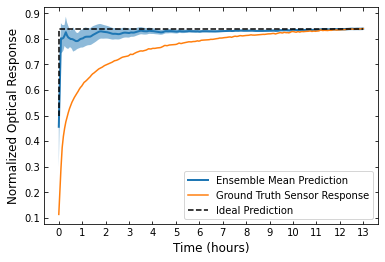

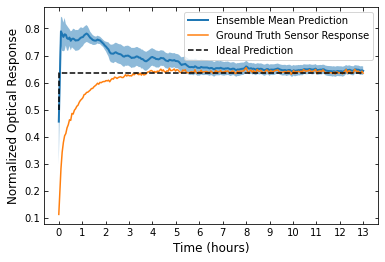

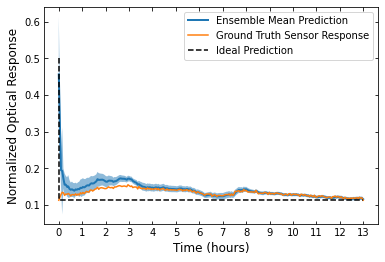

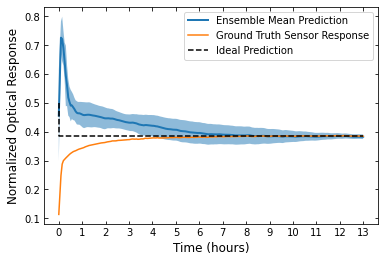

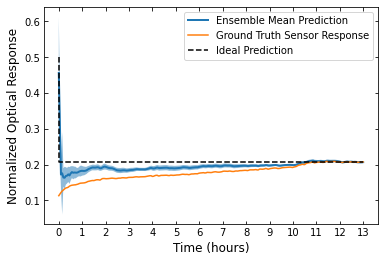

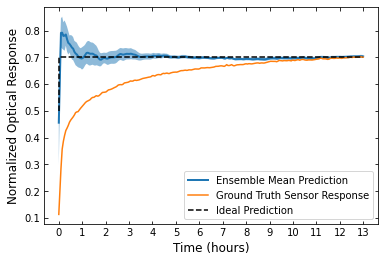

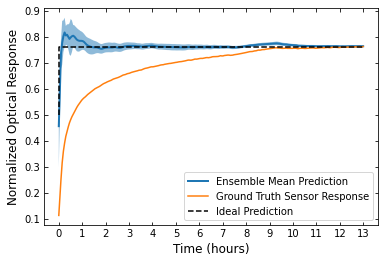

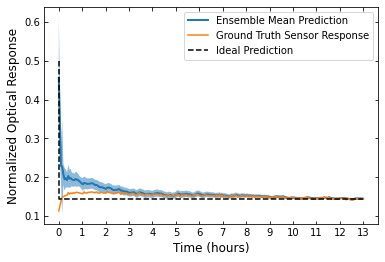

In [2]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
# standard deviations away from the mean used to show confidence interval
# 1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively
StdevsFromMean = 2
test_split = 0.2

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)

X_test = np.expand_dims(X_test, 2)
    
Mean = tf.zeros([len(X_test),SequenceLength])
Variance = tf.zeros([len(X_test),SequenceLength])

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_test[0:6,::] for example does give identical results to predicting any one indivdually..
    prediction = bestModel.predict(X_test)
        
    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_test[i,::], 0)) for  i in range(len(X_test))])
    
    Mean += prediction[:,:,0]
    Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

# for plotting the ideal model prediction, which instantaneously rises to the equilibrium value at time t=0
idealTime = np.append([0], time.iloc[:,].values)

time = np.array(time, dtype=float)

for mean,variance,x_test in zip(Mean,Variance,X_test):
    
    Stdev = np.squeeze(variance**0.5)
    
    # the ideal prediction is ~0.5 on the normalized sensor response scale initially,
    # then jumps to the equilibrium sensor response and remains there for all subsequent time points
    idealPrediction = np.ones(len(idealTime))*x_test[-1,0,0]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    # uncertainty is displayed by a shaded region a specified number of standard deviations from the mean
    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x_test), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()

<a id='FiguresExperimentalDataModelSection7'></a>
## 7. Plot of individual base learner predictions, aggregated ensemble prediction, and experimental sensor response
[return to top](#FigureExperimentalDataModelTop)

1/1 [==============================] - 0s 377ms/step


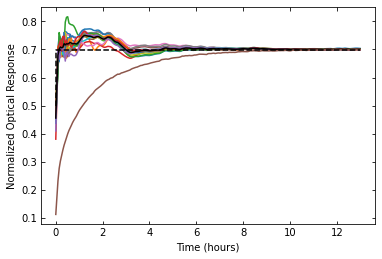

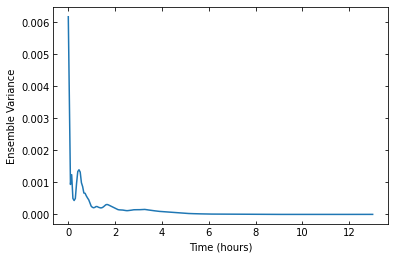

In [7]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import LSTMutils

# input parameters
NumEnsemble = 15
SequenceLength = 250
predict_num = 5
test_split = 0.2

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
time, concentrations, df_data, unused = ExperimentalData.ReadData()

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

# Define y as the last element in X, and ensure X and y are the correct shape
X_test, y_test = ExperimentalData.Shape(df_norm_test)

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X_test[predict_num,::], 0)

# the ideal prediction is ~0.5 on the normalized sensor response scale initially,
# then jumps to the equilibrium sensor response and remains there for all subsequent time points
idealTime = np.append([0], time.iloc[:,].values)
idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
idealPrediction[0] = 0.5

fig, ax = plt.subplots()

# predict equilibrium sensor response for each base LSTM learner in the ensemble
# at every time point for each experimental example
# implementation follows this work: doi.org/10.48550/arXiv.1612.01474
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_predict[0:6,::] for example does give identical results to predicting any one indivdually..
    prediction = bestModel.predict(X_predict)
    
    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_predict[i,::], 0)) for  i in range(len(X_predict))])
    
    plt.plot(time,tf.squeeze(prediction[:,:,0]),label=f"model {NumEnsemble} Prediction")
    Mean += prediction[:,:,0]
    Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2

Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

plt.plot(time,tf.squeeze(Mean),label="Mean Prediction",color='k')
plt.plot(time,tf.squeeze(X_predict), label="Ground Truth Sensor Response")
plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Optical Response")
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.show()

fig, ax = plt.subplots()
plt.plot(time,tf.squeeze(Variance), label="Variance")
plt.xlabel("Time (hours)")
plt.ylabel("Ensemble Variance")
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.show()

<a id='FiguresExperimentalDataModelAlternativeModels'></a>
## Comparison of Different Types of Recurrent Neural Network

Different architectures were compared to see which is most effective: ensembles of 1) traditional 'vanilla' recurrent neural networks (RNN), 2) Gated Recurrent Unit (GRU) networks, and 3) LSTM networks

8. [Comparison of LSTM, GRU and RNN mean factor of improvement in t90 response time as a function of concentration](#FiguresDataSection8)
9. [Comparison of LSTM, GRU and RNN median factor of improvement in t90 response time as a function of concentration](#FiguresDataSection9)

<a id='FiguresExperimentalDataModelSection8'></a>
## 8. Comparison of LSTM, GRU and RNN mean factor of improvement in t90 response time as a function of concentration
[return to top](#FigureExperimentalDataModelTop)

1/1 [==============================] - 0s 162ms/step


1/1 [==============================] - 0s 241ms/step


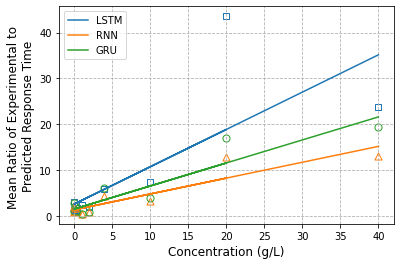

In [2]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import LSTMutils

# input parameters
NumEnsemble = 10
SequenceLength = 250
# t90 time is defined as the time until the response settles to within the following fraction of
# the equilibrium response indefinitely
t90Window = 0.1
test_split = 0.2
markerSize = 50

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
unused, unused, unused, df_data_with_concentrations = ExperimentalData.ReadData(ConcentrationAsIndex=0)
concentrations = df_data_with_concentrations.index

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data_with_concentrations, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

fig, ax = plt.subplots()
MeanPredictionT90LSTM = []
MeanPredictionT90RNN = []
MeanPredictionT90GRU = []
MeanExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

# calculate response time improvement afforded by lstm, gru and rnn grouped by concentration
UniqueConcentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
for concentration in UniqueConcentrations:
    
    # Define y as the last element in X, and ensure X and y are the correct shape
    X_test, y_test = ExperimentalData.Shape(df_norm_test.loc[concentration,:])
    
    MeanLSTM = tf.zeros([len(X_test),SequenceLength])
    MeanRNN = tf.zeros([len(X_test),SequenceLength])
    MeanGRU = tf.zeros([len(X_test),SequenceLength])
    PredictionLSTM = tf.zeros([len(X_test),SequenceLength])
    PredictionRNN = tf.zeros([len(X_test),SequenceLength])
    PredictionGRU = tf.zeros([len(X_test),SequenceLength])
    
    # predict equilibrium sensor response for each base LSTM learner in the ensemble
    # at every time point for each experimental example
    # implementation follows this work: doi.org/10.48550/arXiv.1612.01474
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_test[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X_test)
        PredictionRNN = bestModelRNN.predict(X_test)
        PredictionGRU = bestModelGRU.predict(X_test)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_test[i,::], 0)) for  i in range(len(X_test))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]

    MeanLSTM /= NumEnsemble
    MeanRNN /= NumEnsemble
    MeanGRU /= NumEnsemble
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for x_test,meanlstm,meanrnn,meangru in zip(X_test,MeanLSTM,MeanRNN,MeanGRU):

        # boolean array for each experimental sensor response time series of when the model prediction or experimental response
        # was within +/-10% of the final equilibrium experimental sensor response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x_test[-1]*(1-t90Window))&(meanlstm < x_test[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x_test[-1]*(1-t90Window))&(meanrnn < x_test[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x_test[-1]*(1-t90Window))&(meangru < x_test[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x_test > x_test[-1]*(1-t90Window))&(x_test < x_test[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model prediction or experimental measurement
        # was outisde the range of final equilibrium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    # factor of improvement in mean t90 response time (ratio of experimental/predicted t90 time)
    # for lstm, rnn, and gru
    meanpredictiont90lstm = np.mean(PredictionT90LSTM)
    meanpredictiont90rnn = np.mean(PredictionT90RNN)
    meanpredictiont90gru = np.mean(PredictionT90GRU)
    meanexperimentalt90 = np.mean(ExperimentalT90)
    ratiot90lstm = meanexperimentalt90/meanpredictiont90lstm
    ratiot90rnn = meanexperimentalt90/meanpredictiont90rnn
    ratiot90gru = meanexperimentalt90/meanpredictiont90gru
    
    MeanPredictionT90LSTM.append(meanpredictiont90lstm)
    MeanPredictionT90RNN.append(meanpredictiont90rnn)
    MeanPredictionT90GRU.append(meanpredictiont90gru)
    MeanExperimentalT90.append(meanexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
    ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="tab:green", marker='o', s=markerSize)
 
UniqueConcentrations = [float(i) for i in UniqueConcentrations]

# fit linear line of best fit for each RNN architecture
LinearFit = LinearRegression()
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="RNN",color="tab:orange")
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="GRU",color="tab:green")

ax.set_ylabel('Mean Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)
plt.legend()
plt.grid(which='major',linestyle='--')

plt.savefig("../Figures/t90ReductionLSTMvsRNNvsGRUvsConcentrationMean.png", dpi=200, bbox_inches='tight')
plt.show()

<a id='FiguresExperimentalDataModelSection9'></a>
## 9. Comparison of LSTM, GRU and RNN median factor of improvement in t90 response time as a function of concentration
[return to top](#FigureExperimentalDataModelTop)

1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 240ms/step


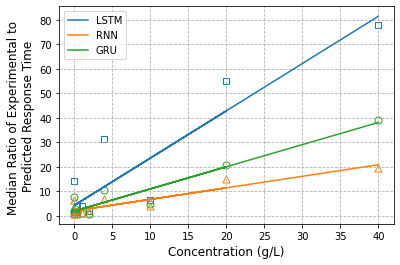

In [5]:
# supress tensorflow logs
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import LSTMutils

# input parameters
NumEnsemble = 10
SequenceLength = 250
# t90 time is defined as the time until the response settles to within the following fraction of
# the equilibrium response indefinitely
t90Window = 0.1
test_split = 0.2
markerSize = 50

# read experimental dataset
ExperimentalData = LSTMutils.ExperimentalData(SequenceLength=SequenceLength)
unused, unused, unused, df_data_with_concentrations = ExperimentalData.ReadData(ConcentrationAsIndex=0)
concentrations = df_data_with_concentrations.index

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str is used here)
df_train, df_test = train_test_split(df_data_with_concentrations, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=concentrations)

# normalise time series data
df_norm_train, df_norm_test, unused = ExperimentalData.NormalizeData(df_train,df_test)

fig, ax = plt.subplots()
MedianPredictionT90LSTM = []
MedianPredictionT90RNN = []
MedianPredictionT90GRU = []
MedianExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

# calculate response time improvement afforded by lstm, gru and rnn grouped by concentration
UniqueConcentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
for concentration in UniqueConcentrations:
    
    # Define y as the last element in X, and ensure X and y are the correct shape
    X_test, y_test = ExperimentalData.Shape(df_norm_test.loc[concentration,:])
    
    MeanLSTM = tf.zeros([len(X_test),SequenceLength])
    MeanRNN = tf.zeros([len(X_test),SequenceLength])
    MeanGRU = tf.zeros([len(X_test),SequenceLength])
    PredictionLSTM = tf.zeros([len(X_test),SequenceLength])
    PredictionRNN = tf.zeros([len(X_test),SequenceLength])
    PredictionGRU = tf.zeros([len(X_test),SequenceLength])
    
    # predict equilibrium sensor response for each base LSTM learner in the ensemble
    # at every time point for each experimental example
    # implementation follows this work: doi.org/10.48550/arXiv.1612.01474
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_test[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X_test)
        PredictionRNN = bestModelRNN.predict(X_test)
        PredictionGRU = bestModelGRU.predict(X_test)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X_test[i,::], 0)) for  i in range(len(X_test))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]

    MeanLSTM /= NumEnsemble
    MeanRNN /= NumEnsemble
    MeanGRU /= NumEnsemble
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for x_test,meanlstm,meanrnn,meangru in zip(X_test,MeanLSTM,MeanRNN,MeanGRU):

        # boolean array for each experimental sensor response time series of when the model prediction or experimental response
        # was within +/-10% of the final equilibrium experimental sensor response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x_test[-1]*(1-t90Window))&(meanlstm < x_test[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x_test[-1]*(1-t90Window))&(meanrnn < x_test[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x_test[-1]*(1-t90Window))&(meangru < x_test[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x_test > x_test[-1]*(1-t90Window))&(x_test < x_test[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model prediction or experimental measurement
        # was outisde the range of final equilibrium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
    # factor of improvement in median t90 response time (ratio of experimental/predicted t90 time)
    # for lstm, rnn, and gru
    medianpredictiont90lstm = np.median(PredictionT90LSTM)
    medianpredictiont90rnn = np.median(PredictionT90RNN)
    medianpredictiont90gru = np.median(PredictionT90GRU)
    medianexperimentalt90 = np.median(ExperimentalT90)
    ratiot90lstm = medianexperimentalt90/medianpredictiont90lstm
    ratiot90rnn = medianexperimentalt90/medianpredictiont90rnn
    ratiot90gru = medianexperimentalt90/medianpredictiont90gru
    
    MedianPredictionT90LSTM.append(medianpredictiont90lstm)
    MedianPredictionT90RNN.append(medianpredictiont90rnn)
    MedianPredictionT90GRU.append(medianpredictiont90gru)
    MedianExperimentalT90.append(medianexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
    ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="tab:green", marker='o', s=markerSize)
 
UniqueConcentrations = [float(i) for i in UniqueConcentrations]

# fit linear line of best fit for each RNN architecture
LinearFit = LinearRegression()
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="RNN",color="tab:orange")
LinearFit.fit(np.reshape(UniqueConcentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
ax.plot(UniqueConcentrations,LinearFit.predict(np.reshape(UniqueConcentrations,(-1, 1))),label="GRU",color="tab:green")

ax.set_ylabel('Median Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)
plt.legend()
plt.grid(which='major',linestyle='--')

plt.savefig("../Figures/t90ReductionLSTMvsRNNvsGRUvsConcentrationMedian.png", dpi=200, bbox_inches='tight')
plt.show()